# H6 Linear Combination of Unitaries

Trotterization approximates time evolution by reexpressing the full Taylor series as a product of simpler Taylor series

![](https://codebook.xanadu.ai/pics/h-circuit.svg)

### Codercise H.6.1.
(a) Write a circuit for applying a sum of unitaries non-deterministically. Don't worry about initialization of the state just yet.

Tip. Use qml.ControlledQubitUnitary to apply these unitaries with control bits.

In [ ]:
aux = 0
main = 1
n_bits = 2
dev = qml.device("default.qubit", wires=n_bits)

def add_two_unitaries(U, V):
    """A circuit to apply the sum of two unitaries non-deterministically.

    Args:
        U (array): A unitary matrix, stored as a complex array.
        V (array): A unitary matrix, stored as a complex array.
    """
    qml.Hadamard(wires=aux)
    ##################
    # YOUR CODE HERE #
    ##################
    qml.ControlledQubitUnitary(U,control_wires=[0], wires=1,control_values='0')
    qml.ControlledQubitUnitary(V,control_wires=[0], wires=1,control_values='1')
    qml.Hadamard(wires=aux)


(b) Complete the code below to apply the sum  to the state  (on the main register). You can invoke add_two_unitaries(U, V) from the last challenge, and access the matrix form of the Paulis using, e.g., qml.PauliX.matrix.

Note that . Are the results what you expect?

In [ ]:
@qml.qnode(dev)
def X_plus_Z():
    """Apply X + Z to |0> and return the state."""
    ##################
    # YOUR CODE HERE #
    ##################
    U = qml.PauliX.compute_matrix()
    V = qml.PauliZ.compute_matrix()
    add_two_unitaries(U,V)
    return qml.state()

print("The amplitudes on the main register are proportional to", X_plus_Z()[:2], ".")


![](https://codebook.xanadu.ai/pics/su-circuit.svg)

### Codercise H.6.2.
(a) Finish the code below to implement the SELECT subcircuit.

In [ ]:
k_bits = 2
n_bits = 2
all_bits = k_bits + n_bits
aux = range(k_bits)
main = range(k_bits, all_bits)
dev = qml.device("default.qubit", wires=all_bits)

def SELECT_uniform(U_list):
    """Implement the SELECT subroutine for 2^k unitaries.

    Args:
        U_list (list[array[complex]]): A list of unitary matrices, stored as
        complex arrays.
    """
    for index in range(2**k_bits):
        ctrl_str =  np.binary_repr(index, k_bits) # Create binary representation
        ##################
        # YOUR CODE HERE #
        ##################
        qml.ControlledQubitUnitary(U_list[index], control_wires =[i for i in range(k_bits)], wires = [i for i in range(n_bits, all_bits)], control_values=ctrl_str)


(b) Write a circuit to apply

In [ ]:
@qml.qnode(dev)
def XH_plus_HZ():
    """Apply XH + HZ to |01> and return the state."""
    U_list = [np.kron(qml.PauliX.compute_matrix(), qml.PauliX.compute_matrix()),
              np.kron(qml.PauliZ.compute_matrix(), qml.PauliZ.compute_matrix()),
              np.kron(qml.PauliX.compute_matrix(), qml.PauliZ.compute_matrix()),
              np.kron(qml.PauliZ.compute_matrix(), qml.PauliX.compute_matrix())]
    ##################
    # YOUR CODE HERE #
    ##################
    qml.PauliX(wires=3)
    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)
    SELECT_uniform(U_list)
    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)
    return qml.state()

print("The amplitudes on the main register are proportional to", XH_plus_HZ()[:4], ".")


![](https://codebook.xanadu.ai/pics/vk-circuit.svg)

### Codercise H.6.3.
(a) Consider the matrix exponential of a unitary operator :

In [ ]:
def V(t):
    """Matrix for the PREPARE subroutine."""
    return np.array([[np.sqrt(t)/np.sqrt(t+1), -1/np.sqrt(t+1)],
                    [1/np.sqrt(t+1), np.sqrt(t)/np.sqrt(t+1)]])

def exp_U_first(U, t):
    """Implement the first two terms in the Taylor series for exp(tU).

    Args:
        U (array): A unitary matrix, stored as a complex array.
        t (float): A time to evolve by.
    """
    ##################
    # YOUR CODE HERE #
    ##################
    qml.QubitUnitary(V(t), wires=0)
    qml.ControlledQubitUnitary(U,control_wires=[0], wires=1, control_values='0')
    qml.ControlledQubitUnitary(np.identity(2),control_wires=[0], wires=1, control_values='0')
    qml.adjoint(qml.QubitUnitary)(V(t),wires=0)




b) Now implement the second-order approximation to ,

In [ ]:
def exp_U_second(U, t):
    """Implement the second-order approximation of exp(tU).

    Args:
        U (array): A unitary matrix, stored as a complex array.
        t (float): A time to evolve by.
    """
    qml.QubitUnitary(V(t), wires=aux[0])
    def subcircuit():
        ##################
        # YOUR CODE HERE #
        ##################
        qml.QubitUnitary(V(t/2), wires=aux[1])
        qml.ControlledQubitUnitary(np.matmul(U,U), control_wires=aux[1], wires=main, control_values='0')
        qml.ControlledQubitUnitary(U, control_wires=aux[1], wires=main, control_values='1')
        qml.QubitUnitary(np.transpose(V(t/2)), wires=aux[1])
    qml.PauliX(wires=aux[0])
    c = qml.ctrl(subcircuit,aux[0])
    c()
    qml.PauliX(wires=aux[0])

    # ADD CONTROLLED OPERATION HERE
    qml.QubitUnitary(np.transpose(V(t)), wires=aux[0])


(c) Finally, write circuits which implement the evolution , starting in the  state, using the (i) the first-order approximation, (ii) the second-order approximation, and (iii) the full series via qml.RX. The functions exp_U_first and exp_U_second from the previous two exercises are available.

In [ ]:
aux = [0, 1]
main = 2
all_bits = range(3)
dev = qml.device("default.qubit", wires=all_bits)

# Part (i)

@qml.qnode(dev)
def first_approx(t):
    ##################
    # YOUR CODE HERE #
    ##################
    exp_U_first(1j * qml.PauliX.compute_matrix(),t)
    return qml.state()

# Part (ii)

@qml.qnode(dev)
def second_approx(t):
    ##################
    # YOUR CODE HERE #
    ##################
    exp_U_second(1j * qml.PauliX.compute_matrix(),t)
    return qml.state()

# Part (iii)

@qml.qnode(dev)
def full_series(t):
    ##################
    # YOUR CODE HERE #
    ##################
    qml.RX(-2 * t,wires=main)

    return qml.state()

##################
# HIT SUBMIT FOR #
# PLOTTING MAGIC #
##################


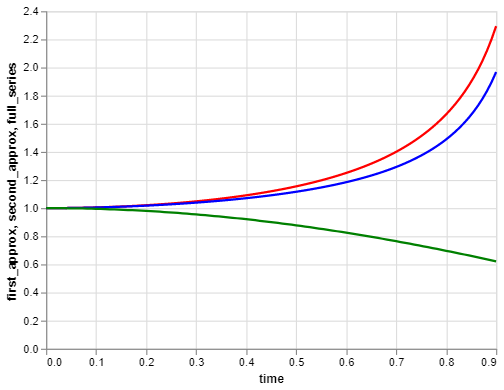